# Wind Energy Output Model

## Implementation of a model to evaluate the wind energy produced at a given time in France according to meteorological data

## 1. Problem and Data Science Solution

#### Topic proposal: Implementation of a model to evaluate the wind energy produced at a given time in France according to meteorological data.


Objective: the idea here is not to make the best possible model and evaluate future improvements that can be implemented. 

No additional data was used for this exercise. For simplicity, the problem was reduced to the region of Ile-de-France, as that is where I live.

#### Import and Set Global Parameters

In [312]:
import datetime
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
LOUD = True
# Set the style
plt.style.use('fivethirtyeight')

## 2. Data Extraction & Preprocessing

### Read in CSV Files

#### Data Sources
The following were the primary data sources for the exercise:

- To find the wind power produced region by region between 2013 and 2022: https://opendata.reseaux-energies.fr/explore/dataset/eco2mix-regional-cons-def 
- To find the evolution of the installed wind power per region between 2001 and 2021: [https://opendata.reseaux- energies.fr/explore/?q=parc+ annual+de+production+éolien+ et+solaire&disjunctive.theme& disjunctive.publisher& disjunctive .geographical &disjunctive-mesh. update-frequency& disjunctive.time-step&sort= explore.popularity_score](https://opendata.reseaux-energies.fr/explore/?q=parc+annuel+de+production+%C3%A9olien+et+solaire&disjunctive.theme&disjunctive.publisher&disjunctive.maille-geographique&disjunctive.frequence-de-mise-a-jour&disjunctive.pas-temporel&sort=explore.popularity_score)
- Weather data per region from 2010 to 2022: [https://public.opendatasoft. com/explore/dataset/donnees- synop-essentiels-omm](https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm)

Each data source was exported as a csv file, then read in as a Pandas dataframe for cleaning and preprocessing.

#### Read in CSV as Panda Dataframes

In [313]:
df_weather = pd.read_csv("/home/jtotiker/Documents/DataScience/Projects/metroscope_project/donnees-synop-essentielles-omm.csv",
                         sep=';')
df_windoutput = pd.read_csv("/home/jtotiker/Documents/DataScience/Projects/metroscope_project/eco2mix-regional-cons-def.csv",
                            sep=';')
df_production = pd.read_csv("/home/jtotiker/Documents/DataScience/Projects/metroscope_project/parc-regional-annuel-prod-eolien-solaire.csv", 
                            sep=';')

#### Initial Preprocessing

- Keep only wind related data for wind production and output history
- For simplicity, keep only weather fields that believe will have highest correlation to wind energy output
- Rename columns
- Convert timestamps to datetime

In [314]:
df_production = df_production.drop(['Géo-shape région', 'Géo-point région', "Parc installé solaire (MW)"], axis=1)
df_windOutput = df_windoutput[['Code INSEE région','Région','Nature','Date','Heure','Date - Heure', 'Eolien (MW)',
                               'TCH Eolien (%)']]
df_weather = df_weather[['ID OMM station','Date', 'Pression au niveau mer', 'Direction du vent moyen 10 mn', 
                        'Vitesse du vent moyen 10 mn', 'Température (°C)', 'Humidité', 'Pression station',
                        'Rafale sur les 10 dernières minutes', 'Rafales sur une période',
                         'Periode de mesure de la rafale',
                         'Précipitations dans les 3 dernières heures','mois_de_l_annee']]

df_windOutput['Date - Heure'] = pd.to_datetime(df_windoutput['Date - Heure'], utc=True)
df_weather['Date'] = pd.to_datetime(df_weather['Date'], utc=True)

df_production = df_production.rename(columns={'Année': 'Year', "Région":"Region", 
                                              "Parc installé éolien (MW)":"Installed_MW"})
df_windOutput = df_windOutput.rename(columns={"Date - Heure":"Timestamp", "Eolien (MW)": "Wind_MW",
                                              "TCH Eolien (%)" : "TCH_per"})
df_weather = df_weather.rename(columns={"Pression au niveau mer": "pressureSeaLevel_Pa", "Direction du vent moyen 10 mn":
                          "meanWindDir_10min", "Vitesse du vent moyen 10 mn" : "meanWindSpeed10min_mps",
                          "Température (°C)" : "temperature_C", "Humidité" : "humidity_per",
                          "Pression station" : "pressureStation", "Rafale sur les 10 dernières minutes" :
                          "gusts_10min", "Rafales sur une période" : "gustSpeed_mps", "Periode de mesure de la rafale":
                          "gustPeriodMeasure", 'Précipitations dans les 3 dernières heures':'rainfall3h_mm',
                          'mois_de_l_annee': 'monthNumber'})

In [315]:
# If wanted, print out data frames after initial preprocessing
if LOUD:
    print('WIND PRODUCTION')
    print(df_production.info())
    print(df_production.shape)
    print('WIND OUTPUT')
    print(df_windOutput.info())
    print(df_windOutput.shape)
    print('WEATHER')
    print(df_weather.info())
    print(df_weather.shape)

WIND PRODUCTION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               21 non-null     int64  
 1   Code INSEE région  21 non-null     int64  
 2   Region             21 non-null     object 
 3   Installed_MW       16 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 800.0+ bytes
None
(21, 4)
WIND OUTPUT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165024 entries, 0 to 165023
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Code INSEE région  165024 non-null  int64              
 1   Région             165024 non-null  object             
 2   Nature             165024 non-null  object             
 3   Date               165024 non-null  object             
 4   Heure              16

#### Cleaning of Wind Production
- Grab Year Number
- Filter to keep only everything from 2013 and on
- Sort by Year so we can see our values in order
- Check null values - none found

In [316]:
df_production['Year'] = pd.to_datetime(df_production['Year'], format='%Y')
df_production['Year'] = pd.DatetimeIndex(df_production['Year']).year
df_production = df_production[df_production['Year'] >= 2013] 
df_production.sort_values('Year',inplace=True)
df_production.isnull().sum()

Year                 0
Code INSEE région    0
Region               0
Installed_MW         0
dtype: int64

#### Cleaning of Wind Farm Outputs
- Grab hour, Day, Month, and Year number from timestamp
- Filter to keep only information from 2013 and on
- Set the Timestamp as the index and sort by those values
- Check null values

In [317]:
df_windOutput['Year'] = pd.DatetimeIndex(df_windOutput['Timestamp']).year
df_windOutput['Hour'] = pd.DatetimeIndex(df_windOutput['Timestamp']).hour
df_windOutput['MonthNum'] = pd.DatetimeIndex(df_windOutput['Timestamp']).month
df_windOutput['DayNum'] = pd.DatetimeIndex(df_windOutput['Timestamp']).day
df_windOutput = df_windOutput[df_windOutput['Year'] >= 2013]
df_windOutput.set_index('Timestamp',inplace=True)
df_windOutput.sort_values('Timestamp',inplace=True)
df_windOutput.isnull().sum()

Code INSEE région         0
Région                    0
Nature                    0
Date                      0
Heure                     0
Wind_MW                  48
TCH_per              122686
Year                      0
Hour                      0
MonthNum                  0
DayNum                    0
dtype: int64

We have quite a few null values for our TCH percentage and a few for our Wind Energy output. For times sake and simplicity we will populate these with the mean values for each value during that year.

In [318]:
df_windOutput['Wind_MW'] = df_windOutput['Wind_MW'].fillna(df_windOutput.groupby('Year')['Wind_MW'].transform('mean'))
df_windOutput['TCH_per'] = df_windOutput['TCH_per'].fillna(df_windOutput.groupby('Year')['TCH_per'].transform('mean'))
df_windOutput.isnull().sum()

Code INSEE région         0
Région                    0
Nature                    0
Date                      0
Heure                     0
Wind_MW                   0
TCH_per              105168
Year                      0
Hour                      0
MonthNum                  0
DayNum                    0
dtype: int64

We still have some TCH values with null values, which upon inspection revealed that in the year 2019 there is no values to be found. We will find a workaround, by first joining our Installed MW value from the production dataframe.

In [319]:
#a['col2'] = a['to_merge_on'].map(b.set_index('to_merge_on')['col2'])
df_windOutput['Installed_MW'] = df_windOutput['Year'].map(df_production.set_index('Year')['Installed_MW'])
df_windOutput.isnull().sum()

Code INSEE région         0
Région                    0
Nature                    0
Date                      0
Heure                     0
Wind_MW                   0
TCH_per              105168
Year                      0
Hour                      0
MonthNum                  0
DayNum                    0
Installed_MW           7246
dtype: int64

- Rechecking our null values, found that there our join above worked well, but we have some null Installed_MW. 
- Now lets make the assumption (perhaps ill-advised) that the full installed capacity from the production table was also serviceable (no downtime/maintenance) to backwards calculate the TCH percentage
- 2019 remains zeroed out 2019, so do a manual rewrite of those values

In [320]:
df_windOutput['TCH_per'] = df_windOutput['TCH_per'].fillna(df_windOutput['Wind_MW']/df_windOutput['Installed_MW'] * 100)
df_windOutput['TCH_per'] = np.where(df_windOutput['Year']==2019, df_windOutput['Wind_MW']/df_windOutput['Installed_MW']*100, df_windOutput['TCH_per'])
df_windOutput.isnull().sum()

Code INSEE région       0
Région                  0
Nature                  0
Date                    0
Heure                   0
Wind_MW                 0
TCH_per                 0
Year                    0
Hour                    0
MonthNum                0
DayNum                  0
Installed_MW         7246
dtype: int64

Not the cleanest looking graph, but enough to see that the gaps are all filled in for our history of TCH, and the values are in physically realistic ranges.

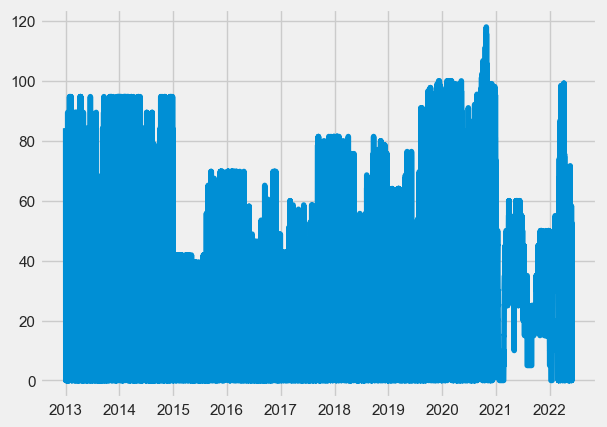

In [321]:
plt.plot(df_windOutput.index, df_windOutput['TCH_per'])
plt.show()

To fill in our installed power values, we again do some back calculations, using the output and TCH percentage to calculate how much was installed for the missing year.

In [322]:
df_windOutput['Installed_MW'] = df_windOutput['Installed_MW'].fillna(df_windOutput['Wind_MW']/df_windOutput['TCH_per']*100)
df_windOutput.head()

Code INSEE région         Région  \
Timestamp                                                     
2013-01-01 00:00:00+00:00                 11  Île-de-France   
2013-01-01 00:30:00+00:00                 11  Île-de-France   
2013-01-01 01:00:00+00:00                 11  Île-de-France   
2013-01-01 01:30:00+00:00                 11  Île-de-France   
2013-01-01 02:00:00+00:00                 11  Île-de-France   

                                        Nature        Date  Heure  Wind_MW  \
Timestamp                                                                    
2013-01-01 00:00:00+00:00  Données définitives  2013-01-01  01:00     16.0   
2013-01-01 00:30:00+00:00  Données définitives  2013-01-01  01:30     15.0   
2013-01-01 01:00:00+00:00  Données définitives  2013-01-01  02:00     15.0   
2013-01-01 01:30:00+00:00  Données définitives  2013-01-01  02:30     16.0   
2013-01-01 02:00:00+00:00  Données définitives  2013-01-01  03:00     16.0   

                             TCH_per  Year  Hour  MonthNum  DayNum  \
Timestamp                                                            
2013-01-01 00:00:00+00:00  84.210526  2013     0         1       1   
2013-01-01 00:30:00+00:00  78.947368  2013     0         1       1   
2013-01-01 01:00:00+00:00  78.947368  2013     1         1       1   
2013-01-01 01:30:00+00:00  84.210526  2013     1         1       1   
2013-01-01 02:00:00+00:00  84.210526  2013     2         1       1   

                           Installed_MW  
Timestamp                                
2013-01-01 00:00:00+00:00          19.0  
2013-01-01 00:30:00+00:00          19.0  
2013-01-01 01:00:00+00:00          19.0  
2013-01-01 01:30:00+00:00          19.0  
2013-01-01 02:00:00+00:00          19.0

#### Cleaning of Weather
- Convert year to datetime
- Sort values by year
- Filter to keep only information from 2013 and on
- Set the Date as the index
- Check null values

In [323]:
df_weather['Year'] = pd.DatetimeIndex(df_weather['Date']).year
df_weather = df_weather[df_weather['Year'] >= 2013] 
df_weather.sort_values('Date',inplace=True)
df_weather.set_index('Date', inplace=True)
df_weather.isnull().sum()

ID OMM station               0
pressureSeaLevel_Pa          1
meanWindDir_10min            1
meanWindSpeed10min_mps       1
temperature_C                1
humidity_per                 1
pressureStation              1
gusts_10min               5808
gustSpeed_mps               10
gustPeriodMeasure            9
rainfall3h_mm               59
monthNumber                  0
Year                         0
dtype: int64

As before, we will fill our na values with the yearly averages for the values for most of the values, and zero out a few others.

In [324]:
df_weather['pressureSeaLevel_Pa'] = df_weather['pressureSeaLevel_Pa'].fillna(df_weather.groupby('Year')['pressureSeaLevel_Pa'].transform('mean'))
df_weather['meanWindDir_10min'] = df_weather['meanWindDir_10min'].fillna(df_weather.groupby('Year')['meanWindDir_10min'].transform('mean'))
df_weather['meanWindSpeed10min_mps'] = df_weather['meanWindSpeed10min_mps'].fillna(df_weather.groupby('Year')['meanWindSpeed10min_mps'].transform('mean'))
df_weather['temperature_C'] = df_weather['temperature_C'].fillna(df_weather.groupby('Year')['temperature_C'].transform('mean'))
df_weather['humidity_per'] = df_weather['humidity_per'].fillna(df_weather.groupby('Year')['humidity_per'].transform('mean'))
df_weather['pressureStation'] = df_weather['pressureStation'].fillna(df_weather.groupby('Year')['pressureStation'].transform('mean'))
df_weather['gusts_10min'].fillna(0, inplace=True)
df_weather['gustSpeed_mps'].fillna(0, inplace=True)
df_weather['gustPeriodMeasure'].fillna(0, inplace=True)
df_weather['rainfall3h_mm'].fillna(0, inplace=True)
df_weather.isnull().sum()

ID OMM station            0
pressureSeaLevel_Pa       0
meanWindDir_10min         0
meanWindSpeed10min_mps    0
temperature_C             0
humidity_per              0
pressureStation           0
gusts_10min               0
gustSpeed_mps             0
gustPeriodMeasure         0
rainfall3h_mm             0
monthNumber               0
Year                      0
dtype: int64

In [325]:
df_weather.head(10)

ID OMM station  pressureSeaLevel_Pa  \
Date                                                             
2013-01-01 00:00:00+00:00            7149             100680.0   
2013-01-01 03:00:00+00:00            7149             100530.0   
2013-01-01 06:00:00+00:00            7149             100570.0   
2013-01-01 09:00:00+00:00            7149             100860.0   
2013-01-01 12:00:00+00:00            7149             101110.0   
2013-01-01 15:00:00+00:00            7149             101290.0   
2013-01-01 18:00:00+00:00            7149             101550.0   
2013-01-01 21:00:00+00:00            7149             101820.0   
2013-01-02 00:00:00+00:00            7149             102030.0   
2013-01-02 03:00:00+00:00            7149             102220.0   

                           meanWindDir_10min  meanWindSpeed10min_mps  \
Date                                                                   
2013-01-01 00:00:00+00:00              200.0                     6.2   
2013-01-01 03:00:00+00:00              210.0                     4.6   
2013-01-01 06:00:00+00:00              240.0                     3.6   
2013-01-01 09:00:00+00:00              280.0                     4.6   
2013-01-01 12:00:00+00:00              280.0                     3.6   
2013-01-01 15:00:00+00:00              280.0                     4.1   
2013-01-01 18:00:00+00:00              330.0                     3.6   
2013-01-01 21:00:00+00:00              270.0                     2.1   
2013-01-02 00:00:00+00:00              270.0                     3.6   
2013-01-02 03:00:00+00:00              260.0                     3.1   

                           temperature_C  humidity_per  pressureStation  \
Date                                                                      
2013-01-01 00:00:00+00:00            7.6          90.0          99590.0   
2013-01-01 03:00:00+00:00            7.7          93.0          99440.0   
2013-01-01 06:00:00+00:00            8.2          94.0          99480.0   
2013-01-01 09:00:00+00:00            8.3          89.0          99770.0   
2013-01-01 12:00:00+00:00            8.5          77.0         100020.0   
2013-01-01 15:00:00+00:00            8.1          69.0         100190.0   
2013-01-01 18:00:00+00:00            6.1          81.0         100440.0   
2013-01-01 21:00:00+00:00            3.2          90.0         100700.0   
2013-01-02 00:00:00+00:00            2.4          92.0         100900.0   
2013-01-02 03:00:00+00:00            1.0          93.0         101080.0   

                           gusts_10min  gustSpeed_mps  gustPeriodMeasure  \
Date                                                                       
2013-01-01 00:00:00+00:00          0.0           10.8              -10.0   
2013-01-01 03:00:00+00:00          0.0            9.8              -10.0   
2013-01-01 06:00:00+00:00          0.0            5.7              -10.0   
2013-01-01 09:00:00+00:00          0.0            7.2              -10.0   
2013-01-01 12:00:00+00:00          0.0            7.7              -10.0   
2013-01-01 15:00:00+00:00          0.0            5.7              -10.0   
2013-01-01 18:00:00+00:00          0.0            8.7              -10.0   
2013-01-01 21:00:00+00:00          0.0           10.8              -10.0   
2013-01-02 00:00:00+00:00          0.0            4.6              -10.0   
2013-01-02 03:00:00+00:00          0.0            4.1              -10.0   

                           rainfall3h_mm  monthNumber  Year  
Date                                                         
2013-01-01 00:00:00+00:00            2.0            1  2013  
2013-01-01 03:00:00+00:00            4.0            1  2013  
2013-01-01 06:00:00+00:00            2.0            1  2013  
2013-01-01 09:00:00+00:00            1.0            1  2013  
2013-01-01 12:00:00+00:00            0.2            1  2013  
2013-01-01 15:00:00+00:00            0.0            1  2013  
2013-01-01 18:00:00+00:00            0.0            1  2013

#### Filtering to same time ranges and joining
- Get the max time in our wind energy output table, which is the limiting table
- Filter the weather table to include only timestamps within same range

In [326]:
df_windOutput.max()
maxTime = df_windOutput.index.max()
maxTime

Timestamp('2022-05-31 21:30:00+0000', tz='UTC')

In [327]:
df_weather = df_weather[df_weather.index <= maxTime] 

In [328]:
df_weather

ID OMM station  pressureSeaLevel_Pa  \
Date                                                             
2013-01-01 00:00:00+00:00            7149             100680.0   
2013-01-01 03:00:00+00:00            7149             100530.0   
2013-01-01 06:00:00+00:00            7149             100570.0   
2013-01-01 09:00:00+00:00            7149             100860.0   
2013-01-01 12:00:00+00:00            7149             101110.0   
...                                   ...                  ...   
2022-05-31 09:00:00+00:00            7149             101350.0   
2022-05-31 12:00:00+00:00            7149             101330.0   
2022-05-31 15:00:00+00:00            7149             101280.0   
2022-05-31 18:00:00+00:00            7149             101370.0   
2022-05-31 21:00:00+00:00            7149             101600.0   

                           meanWindDir_10min  meanWindSpeed10min_mps  \
Date                                                                   
2013-01-01 00:00:00+00:00              200.0                     6.2   
2013-01-01 03:00:00+00:00              210.0                     4.6   
2013-01-01 06:00:00+00:00              240.0                     3.6   
2013-01-01 09:00:00+00:00              280.0                     4.6   
2013-01-01 12:00:00+00:00              280.0                     3.6   
...                                      ...                     ...   
2022-05-31 09:00:00+00:00              280.0                     1.3   
2022-05-31 12:00:00+00:00              270.0                     2.5   
2022-05-31 15:00:00+00:00              270.0                     2.8   
2022-05-31 18:00:00+00:00              340.0                     3.9   
2022-05-31 21:00:00+00:00              330.0                     3.1   

                           temperature_C  humidity_per  pressureStation  \
Date                                                                      
2013-01-01 00:00:00+00:00            7.6          90.0          99590.0   
2013-01-01 03:00:00+00:00            7.7          93.0          99440.0   
2013-01-01 06:00:00+00:00            8.2          94.0          99480.0   
2013-01-01 09:00:00+00:00            8.3          89.0          99770.0   
2013-01-01 12:00:00+00:00            8.5          77.0         100020.0   
...                                  ...           ...              ...   
2022-05-31 09:00:00+00:00           16.8          49.0         100290.0   
2022-05-31 12:00:00+00:00           21.4          32.0         100280.0   
2022-05-31 15:00:00+00:00           22.1          31.0         100240.0   
2022-05-31 18:00:00+00:00           19.9          40.0         100320.0   
2022-05-31 21:00:00+00:00           15.2          52.0         100530.0   

                           gusts_10min  gustSpeed_mps  gustPeriodMeasure  \
Date                                                                       
2013-01-01 00:00:00+00:00          0.0           10.8              -10.0   
2013-01-01 03:00:00+00:00          0.0            9.8              -10.0   
2013-01-01 06:00:00+00:00          0.0            5.7              -10.0   
2013-01-01 09:00:00+00:00          0.0            7.2              -10.0   
2013-01-01 12:00:00+00:00          0.0            7.7              -10.0   
...                                ...            ...                ...   
2022-05-31 09:00:00+00:00          2.9            7.8              -10.0   
2022-05-31 12:00:00+00:00          5.1            8.3              -10.0   
2022-05-31 15:00:00+00:00          6.7           10.0              -10.0   
2022-05-31 18:00:00+00:00          6.0            8.7              -10.0   
2022-05-31 21:00:00+00:00          5.0            5.6              -10.0   

                           rainfall3h_mm  monthNumber  Year  
Date                                                         
2013-01-01 00:00:00+00:00            2.0            1  2013  
2013-01-01 03:00:00+00:00            4.0            1  2013  
2013-01-01 06:00:0

#### Merging Weather and Wind Output
- Only need to merge our wind output and weather, as the wind output contains our total yearly production capacity information
- The trap here is that the wind output is significantly bigger than weather table, so if we want to avoid loss of information of our target variable, the wind output, the join should be a left join onto the wind Output.
- check shape after merging, we cut some lines, but column values lineup

In [329]:
df = pd.merge(df_windOutput, df_weather, how='left', left_index=True, right_index=True)
df.shape

(165022, 25)

In [330]:
df

Code INSEE région         Région  \
2013-01-01 00:00:00+00:00                 11  Île-de-France   
2013-01-01 00:30:00+00:00                 11  Île-de-France   
2013-01-01 01:00:00+00:00                 11  Île-de-France   
2013-01-01 01:30:00+00:00                 11  Île-de-France   
2013-01-01 02:00:00+00:00                 11  Île-de-France   
...                                      ...            ...   
2022-05-31 19:30:00+00:00                 11  Île-de-France   
2022-05-31 20:00:00+00:00                 11  Île-de-France   
2022-05-31 20:30:00+00:00                 11  Île-de-France   
2022-05-31 21:00:00+00:00                 11  Île-de-France   
2022-05-31 21:30:00+00:00                 11  Île-de-France   

                                        Nature        Date  Heure  Wind_MW  \
2013-01-01 00:00:00+00:00  Données définitives  2013-01-01  01:00     16.0   
2013-01-01 00:30:00+00:00  Données définitives  2013-01-01  01:30     15.0   
2013-01-01 01:00:00+00:00  Données définitives  2013-01-01  02:00     15.0   
2013-01-01 01:30:00+00:00  Données définitives  2013-01-01  02:30     16.0   
2013-01-01 02:00:00+00:00  Données définitives  2013-01-01  03:00     16.0   
...                                        ...         ...    ...      ...   
2022-05-31 19:30:00+00:00  Données consolidées  2022-05-31  21:30     21.0   
2022-05-31 20:00:00+00:00  Données consolidées  2022-05-31  22:00     20.0   
2022-05-31 20:30:00+00:00  Données consolidées  2022-05-31  22:30     27.0   
2022-05-31 21:00:00+00:00  Données consolidées  2022-05-31  23:00     28.0   
2022-05-31 21:30:00+00:00  Données consolidées  2022-05-31  23:30     29.0   

                             TCH_per  Year_x  Hour  MonthNum  ...  \
2013-01-01 00:00:00+00:00  84.210526    2013     0         1  ...   
2013-01-01 00:30:00+00:00  78.947368    2013     0         1  ...   
2013-01-01 01:00:00+00:00  78.947368    2013     1         1  ...   
2013-01-01 01:30:00+00:00  84.210526    2013     1         1  ...   
2013-01-01 02:00:00+00:00  84.210526    2013     2         1  ...   
...                              ...     ...   ...       ...  ...   
2022-05-31 19:30:00+00:00  16.540000    2022    19         5  ...   
2022-05-31 20:00:00+00:00  15.750000    2022    20         5  ...   
2022-05-31 20:30:00+00:00  21.260000    2022    20         5  ...   
2022-05-31 21:00:00+00:00  22.050000    2022    21         5  ...   
2022-05-31 21:30:00+00:00  22.830000    2022    21         5  ...   

                           meanWindSpeed10min_mps  temperature_C  \
2013-01-01 00:00:00+00:00                     6.2            7.6   
2013-01-01 00:30:00+00:00                     NaN            NaN   
2013-01-01 01:00:00+00:00                     NaN            NaN   
2013-01-01 01:30:00+00:00                     NaN            NaN   
2013-01-01 02:00:00+00:00                     NaN            NaN   
...                                           ...            ...   
2022-05-31 19:30:00+00:00                     NaN            NaN   
2022-05-31 20:00:00+00:00                     NaN            NaN   
2022-05-31 20:30:00+00:00                     NaN            NaN   
2022-05-31 21:00:00+00:00                     3.1           15.2   
2022-05-31 21:30:00+00:00                     NaN            NaN   

                           humidity_per  pressureStation  gusts_10min  \
2013-01-01 00:00:00+00:00          90.0          99590.0          0.0   
2013-01-01 00:30:00+00:00           NaN              NaN          NaN   
2013-01-01 01:00:00+00:00           NaN              NaN          NaN   
2013-01-01 01:30:00+00:00           NaN              NaN          NaN   
2013-01-01 02:00:00+00:00           NaN              NaN          NaN   
...                                 ...              ...          ...   
2022-05-31 19:30:00+00:00           NaN              NaN          NaN   
2022-05-31 20:00:00+00:00           NaN              NaN          NaN   
2022-05-31 20:30:00+00:00     

- Recheck for null values in merge
- Cut 2022 as we don't have installed MW data

In [331]:
df.isna().sum()

Code INSEE région              0
Région                         0
Nature                         0
Date                           0
Heure                          0
Wind_MW                        0
TCH_per                        0
Year_x                         0
Hour                           0
MonthNum                       0
DayNum                         0
Installed_MW                 425
ID OMM station            137567
pressureSeaLevel_Pa       137567
meanWindDir_10min         137567
meanWindSpeed10min_mps    137567
temperature_C             137567
humidity_per              137567
pressureStation           137567
gusts_10min               137567
gustSpeed_mps             137567
gustPeriodMeasure         137567
rainfall3h_mm             137567
monthNumber               137567
Year_y                    137567
dtype: int64

In [332]:
df = df[df['Year_x'] < 2022]

In [333]:
df.isna().sum()

Code INSEE région              0
Région                         0
Nature                         0
Date                           0
Heure                          0
Wind_MW                        0
TCH_per                        0
Year_x                         0
Hour                           0
MonthNum                       0
DayNum                         0
Installed_MW                   0
ID OMM station            131529
pressureSeaLevel_Pa       131529
meanWindDir_10min         131529
meanWindSpeed10min_mps    131529
temperature_C             131529
humidity_per              131529
pressureStation           131529
gusts_10min               131529
gustSpeed_mps             131529
gustPeriodMeasure         131529
rainfall3h_mm             131529
monthNumber               131529
Year_y                    131529
dtype: int64

- Making the decision to keep Wind output data over weather data, now have some significant holes in the weather data.
- To fill these values in, a linear trend is assumed between the two valid weather data points to go from one to the next. This is very likely not a correct assumption, but the simplest one to make to move forward with the problem.

In [334]:
df.head(15)

Code INSEE région         Région  \
2013-01-01 00:00:00+00:00                 11  Île-de-France   
2013-01-01 00:30:00+00:00                 11  Île-de-France   
2013-01-01 01:00:00+00:00                 11  Île-de-France   
2013-01-01 01:30:00+00:00                 11  Île-de-France   
2013-01-01 02:00:00+00:00                 11  Île-de-France   
2013-01-01 02:30:00+00:00                 11  Île-de-France   
2013-01-01 03:00:00+00:00                 11  Île-de-France   
2013-01-01 03:30:00+00:00                 11  Île-de-France   
2013-01-01 04:00:00+00:00                 11  Île-de-France   
2013-01-01 04:30:00+00:00                 11  Île-de-France   
2013-01-01 05:00:00+00:00                 11  Île-de-France   
2013-01-01 05:30:00+00:00                 11  Île-de-France   
2013-01-01 06:00:00+00:00                 11  Île-de-France   
2013-01-01 06:30:00+00:00                 11  Île-de-France   
2013-01-01 07:00:00+00:00                 11  Île-de-France   

                                        Nature        Date  Heure  Wind_MW  \
2013-01-01 00:00:00+00:00  Données définitives  2013-01-01  01:00     16.0   
2013-01-01 00:30:00+00:00  Données définitives  2013-01-01  01:30     15.0   
2013-01-01 01:00:00+00:00  Données définitives  2013-01-01  02:00     15.0   
2013-01-01 01:30:00+00:00  Données définitives  2013-01-01  02:30     16.0   
2013-01-01 02:00:00+00:00  Données définitives  2013-01-01  03:00     16.0   
2013-01-01 02:30:00+00:00  Données définitives  2013-01-01  03:30     16.0   
2013-01-01 03:00:00+00:00  Données définitives  2013-01-01  04:00     15.0   
2013-01-01 03:30:00+00:00  Données définitives  2013-01-01  04:30     15.0   
2013-01-01 04:00:00+00:00  Données définitives  2013-01-01  05:00     14.0   
2013-01-01 04:30:00+00:00  Données définitives  2013-01-01  05:30     11.0   
2013-01-01 05:00:00+00:00  Données définitives  2013-01-01  06:00      9.0   
2013-01-01 05:30:00+00:00  Données définitives  2013-01-01  06:30      8.0   
2013-01-01 06:00:00+00:00  Données définitives  2013-01-01  07:00     11.0   
2013-01-01 06:30:00+00:00  Données définitives  2013-01-01  07:30      7.0   
2013-01-01 07:00:00+00:00  Données définitives  2013-01-01  08:00      8.0   

                             TCH_per  Year_x  Hour  MonthNum  ...  \
2013-01-01 00:00:00+00:00  84.210526    2013     0         1  ...   
2013-01-01 00:30:00+00:00  78.947368    2013     0         1  ...   
2013-01-01 01:00:00+00:00  78.947368    2013     1         1  ...   
2013-01-01 01:30:00+00:00  84.210526    2013     1         1  ...   
2013-01-01 02:00:00+00:00  84.210526    2013     2         1  ...   
2013-01-01 02:30:00+00:00  84.210526    2013     2         1  ...   
2013-01-01 03:00:00+00:00  78.947368    2013     3         1  ...   
2013-01-01 03:30:00+00:00  78.947368    2013     3         1  ...   
2013-01-01 04:00:00+00:00  73.684211    2013     4         1  ...   
2013-01-01 04:30:00+00:00  57.894737    2013     4         1  ...   
2013-01-01 05:00:00+00:00  47.368421    2013     5         1  ...   
2013-01-01 05:30:00+00:00  42.105263    2013     5         1  ...   
2013-01-01 06:00:00+00:00  57.894737    2013     6         1  ...   
2013-01-01 06:30:00+00:00  36.842105    2013     6         1  ...   
2013-01-01 07:00:00+00:00  42.105263    2013     7         1  ...   

                           meanWindSpeed10min_mps  temperature_C  \
2013-01-01 00:00:00+00:00                     6.2            7.6   
2013-01-01 00:30:00+00:00                     NaN            NaN   
2013-01-01 01:00:00+00:00                     NaN            NaN   
2013-01-01 01:30:00+00:00                     NaN            NaN   
2013-01-01 02:00:00+00:00                     NaN            NaN   
2013-01-01 02:30:00+00:00                     NaN            NaN   
2013-01-01 03:00:00+00:00                     4.6            7.7   
2013-01-01 03:30:00+00:00                     NaN            NaN   
2013-01-01 04:00:00+00:00                     NaN   

In [335]:
df = df.replace([["pressureSeaLevel_Pa", "meanWindDir_10min", "meanWindSpeed10min_mps", "temperature_C", "humidity_per",
          "gusts_10min", "pressureStation", "gustSpeed_mps", "gustPeriodMeasure", "rainfall3h_mm"]]).interpolate()
df

Code INSEE région         Région  \
2013-01-01 00:00:00+00:00                 11  Île-de-France   
2013-01-01 00:30:00+00:00                 11  Île-de-France   
2013-01-01 01:00:00+00:00                 11  Île-de-France   
2013-01-01 01:30:00+00:00                 11  Île-de-France   
2013-01-01 02:00:00+00:00                 11  Île-de-France   
...                                      ...            ...   
2021-12-31 21:30:00+00:00                 11  Île-de-France   
2021-12-31 22:00:00+00:00                 11  Île-de-France   
2021-12-31 22:30:00+00:00                 11  Île-de-France   
2021-12-31 23:00:00+00:00                 11  Île-de-France   
2021-12-31 23:30:00+00:00                 11  Île-de-France   

                                        Nature        Date  Heure  Wind_MW  \
2013-01-01 00:00:00+00:00  Données définitives  2013-01-01  01:00     16.0   
2013-01-01 00:30:00+00:00  Données définitives  2013-01-01  01:30     15.0   
2013-01-01 01:00:00+00:00  Données définitives  2013-01-01  02:00     15.0   
2013-01-01 01:30:00+00:00  Données définitives  2013-01-01  02:30     16.0   
2013-01-01 02:00:00+00:00  Données définitives  2013-01-01  03:00     16.0   
...                                        ...         ...    ...      ...   
2021-12-31 21:30:00+00:00  Données consolidées  2021-12-31  22:30      9.0   
2021-12-31 22:00:00+00:00  Données consolidées  2021-12-31  23:00     10.0   
2021-12-31 22:30:00+00:00  Données consolidées  2021-12-31  23:30     11.0   
2021-12-31 23:00:00+00:00  Données consolidées  2022-01-01  00:00      6.0   
2021-12-31 23:30:00+00:00  Données consolidées  2022-01-01  00:30      4.0   

                             TCH_per  Year_x  Hour  MonthNum  ...  \
2013-01-01 00:00:00+00:00  84.210526    2013     0         1  ...   
2013-01-01 00:30:00+00:00  78.947368    2013     0         1  ...   
2013-01-01 01:00:00+00:00  78.947368    2013     1         1  ...   
2013-01-01 01:30:00+00:00  84.210526    2013     1         1  ...   
2013-01-01 02:00:00+00:00  84.210526    2013     2         1  ...   
...                              ...     ...   ...       ...  ...   
2021-12-31 21:30:00+00:00  10.000000    2021    21        12  ...   
2021-12-31 22:00:00+00:00  10.000000    2021    22        12  ...   
2021-12-31 22:30:00+00:00  10.000000    2021    22        12  ...   
2021-12-31 23:00:00+00:00  10.000000    2021    23        12  ...   
2021-12-31 23:30:00+00:00  10.000000    2021    23        12  ...   

                           meanWindSpeed10min_mps  temperature_C  \
2013-01-01 00:00:00+00:00                6.200000       7.600000   
2013-01-01 00:30:00+00:00                5.933333       7.616667   
2013-01-01 01:00:00+00:00                5.666667       7.633333   
2013-01-01 01:30:00+00:00                5.400000       7.650000   
2013-01-01 02:00:00+00:00                5.133333       7.666667   
...                                           ...            ...   
2021-12-31 21:30:00+00:00                2.500000      10.500000   
2021-12-31 22:00:00+00:00                2.500000      10.500000   
2021-12-31 22:30:00+00:00                2.500000      10.500000   
2021-12-31 23:00:00+00:00                2.500000      10.500000   
2021-12-31 23:30:00+00:00                2.500000      10.500000   

                           humidity_per  pressureStation  gusts_10min  \
2013-01-01 00:00:00+00:00          90.0          99590.0          0.0   
2013-01-01 00:30:00+00:00          90.5          99565.0          0.0   
2013-01-01 01:00:00+00:00          91.0          99540.0          0.0   
2013-01-01 01:30:00+00:00          91.5          99515.0          0.0   
2013-01-01 02:00:00+00:00          92.0          99490.0          0.0   
...                                 ...              ...          ...   
2021-12-31 21:30:00+00:00          97.0         101580.0          3.3   
2021-12-31 22:00:00+00:00          97.0         101580.0          3.3   
2021-12-31 22:30:00+00:00     

### 3. Data Exploration & Feature Engineering

Now that we have our merged final dataframe, we can start looking our columns and what we want to keep and use as inputs for our model.

- Take month name (originally used as a feature, then removed)
- Calculate daily average of windoutput to use as baseline to be fed in later into our model
- Drop some unneeded columns that won't be used as features
- Some renaming

In [336]:
df['MonthName'] = pd.DatetimeIndex(df['Date']).strftime("%B")
df['RollingAvg'] = df.Wind_MW.rolling(window= 8, min_periods= 1, closed='left').mean()
#df['DailyAvg'] = df.groupby('Date')['Wind_MW'].transform('mean')
df.drop(['Code INSEE région', 'Year_y', 'ID OMM station', 'Nature', 'Région','monthNumber'], axis=1, inplace=True)
df.rename(columns={'Year_x':'Year'}, inplace=True)
df

Date  Heure  Wind_MW    TCH_per  Year  Hour  \
2013-01-01 00:00:00+00:00  2013-01-01  01:00     16.0  84.210526  2013     0   
2013-01-01 00:30:00+00:00  2013-01-01  01:30     15.0  78.947368  2013     0   
2013-01-01 01:00:00+00:00  2013-01-01  02:00     15.0  78.947368  2013     1   
2013-01-01 01:30:00+00:00  2013-01-01  02:30     16.0  84.210526  2013     1   
2013-01-01 02:00:00+00:00  2013-01-01  03:00     16.0  84.210526  2013     2   
...                               ...    ...      ...        ...   ...   ...   
2021-12-31 21:30:00+00:00  2021-12-31  22:30      9.0  10.000000  2021    21   
2021-12-31 22:00:00+00:00  2021-12-31  23:00     10.0  10.000000  2021    22   
2021-12-31 22:30:00+00:00  2021-12-31  23:30     11.0  10.000000  2021    22   
2021-12-31 23:00:00+00:00  2022-01-01  00:00      6.0  10.000000  2021    23   
2021-12-31 23:30:00+00:00  2022-01-01  00:30      4.0  10.000000  2021    23   

                           MonthNum  DayNum  Installed_MW  \
2013-01-01 00:00:00+00:00         1       1          19.0   
2013-01-01 00:30:00+00:00         1       1          19.0   
2013-01-01 01:00:00+00:00         1       1          19.0   
2013-01-01 01:30:00+00:00         1       1          19.0   
2013-01-01 02:00:00+00:00         1       1          19.0   
...                             ...     ...           ...   
2021-12-31 21:30:00+00:00        12      31         127.0   
2021-12-31 22:00:00+00:00        12      31         127.0   
2021-12-31 22:30:00+00:00        12      31         127.0   
2021-12-31 23:00:00+00:00        12      31         127.0   
2021-12-31 23:30:00+00:00        12      31         127.0   

                           pressureSeaLevel_Pa  ...  meanWindSpeed10min_mps  \
2013-01-01 00:00:00+00:00             100680.0  ...                6.200000   
2013-01-01 00:30:00+00:00             100655.0  ...                5.933333   
2013-01-01 01:00:00+00:00             100630.0  ...                5.666667   
2013-01-01 01:30:00+00:00             100605.0  ...                5.400000   
2013-01-01 02:00:00+00:00             100580.0  ...                5.133333   
...                                        ...  ...                     ...   
2021-12-31 21:30:00+00:00             102680.0  ...                2.500000   
2021-12-31 22:00:00+00:00             102680.0  ...                2.500000   
2021-12-31 22:30:00+00:00             102680.0  ...                2.500000   
2021-12-31 23:00:00+00:00             102680.0  ...                2.500000   
2021-12-31 23:30:00+00:00             102680.0  ...                2.500000   

                           temperature_C  humidity_per  pressureStation  \
2013-01-01 00:00:00+00:00       7.600000          90.0          99590.0   
2013-01-01 00:30:00+00:00       7.616667          90.5          99565.0   
2013-01-01 01:00:00+00:00       7.633333          91.0          99540.0   
2013-01-01 01:30:00+00:00       7.650000          91.5          99515.0   
2013-01-01 02:00:00+00:00       7.666667          92.0          99490.0   
...                                  ...           ...              ...   
2021-12-31 21:30:00+00:00      10.500000          97.0         101580.0   
2021-12-31 22:00:00+00:00      10.500000          97.0         101580.0   
2021-12-31 22:30:00+00:00      10.500000          97.0         101580.0   
2021-12-31 23:00:00+00:00      10.500000          97.0         101580.0   
2021-12-31 23:30:00+00:00      10.500000          97.0         101580.0   

                           gusts_10min  gustSpeed_mps  gustPeriodMeasure  \
2013-01-01 00:00:00+00:00          0.0      10.800000              -10.0   
2013-01-01 00:30:00+00:00          0.0      10.633333              -10.0   
2013-01-01 01:00:00+00:00          0.0      10.466667              -10.0   
2013-01-01 01:30:00+00:00          0.0      10.300000              -10.0   
2013-01-01 02:00:00+00:00          0.0      10.133333              -10.0   
...                              

In [337]:
df.isna().sum()


Date                      0
Heure                     0
Wind_MW                   0
TCH_per                   0
Year                      0
Hour                      0
MonthNum                  0
DayNum                    0
Installed_MW              0
pressureSeaLevel_Pa       0
meanWindDir_10min         0
meanWindSpeed10min_mps    0
temperature_C             0
humidity_per              0
pressureStation           0
gusts_10min               0
gustSpeed_mps             0
gustPeriodMeasure         0
rainfall3h_mm             0
MonthName                 0
RollingAvg                1
dtype: int64

- The first value of the rolling average is NAN as there is no data points for it, so it is backfilled from the value of the next timestep

In [338]:
df = df.fillna(method="bfill")
df.isna().sum()

Date                      0
Heure                     0
Wind_MW                   0
TCH_per                   0
Year                      0
Hour                      0
MonthNum                  0
DayNum                    0
Installed_MW              0
pressureSeaLevel_Pa       0
meanWindDir_10min         0
meanWindSpeed10min_mps    0
temperature_C             0
humidity_per              0
pressureStation           0
gusts_10min               0
gustSpeed_mps             0
gustPeriodMeasure         0
rainfall3h_mm             0
MonthName                 0
RollingAvg                0
dtype: int64

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157776 entries, 2013-01-01 00:00:00+00:00 to 2021-12-31 23:30:00+00:00
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Date                    157776 non-null  object 
 1   Heure                   157776 non-null  object 
 2   Wind_MW                 157776 non-null  float64
 3   TCH_per                 157776 non-null  float64
 4   Year                    157776 non-null  int32  
 5   Hour                    157776 non-null  int32  
 6   MonthNum                157776 non-null  int32  
 7   DayNum                  157776 non-null  int32  
 8   Installed_MW            157776 non-null  float64
 9   pressureSeaLevel_Pa     157776 non-null  float64
 10  meanWindDir_10min       157776 non-null  float64
 11  meanWindSpeed10min_mps  157776 non-null  float64
 12  temperature_C           157776 non-null  float64
 13  humidity_per            1577

#### Lets get some descriptive statistics on our fields that we will use as features
- None of the values look like gross outliers or physically impossible values (based on my basic knowledge of wind energy)

In [340]:
df.describe()

Wind_MW        TCH_per           Year           Hour  \
count  157776.000000  157776.000000  157776.000000  157776.000000   
mean       14.118907      21.818697    2017.000608      11.500114   
std        19.295297      22.239169       2.581801       6.922027   
min         0.000000       0.000000    2013.000000       0.000000   
25%         2.000000       4.651163    2015.000000       5.750000   
50%         6.000000      14.606742    2017.000000      11.500000   
75%        18.000000      34.883721    2019.000000      17.250000   
max       126.000000     117.980000    2021.000000      23.000000   

            MonthNum         DayNum   Installed_MW  pressureSeaLevel_Pa  \
count  157776.000000  157776.000000  157776.000000        157776.000000   
mean        6.522475      15.728729      65.116824        101697.660738   
std         3.448625       8.799835      35.512080           917.380731   
min         1.000000       1.000000      19.000000         97050.000000   
25%         4.000000       8.000000      43.000000        101186.666667   
50%         7.000000      16.000000      70.000000        101760.000000   
75%        10.000000      23.000000      89.000000        102280.000000   
max        12.000000      31.000000     127.000000        104720.000000   

       meanWindDir_10min  meanWindSpeed10min_mps  temperature_C  \
count      157776.000000           157776.000000  157776.000000   
mean          185.083976                3.512170      12.403458   
std            97.460538                1.913002       7.162118   
min             0.000000                0.000000      -8.400000   
25%            95.000000                2.100000       7.116667   
50%           205.000000                3.266667      11.933333   
75%           256.666667                4.683333      17.400000   
max           360.000000               14.600000      41.400000   

        humidity_per  pressureStation    gusts_10min  gustSpeed_mps  \
count  157776.000000    157776.000000  157776.000000  157776.000000   
mean       74.463103    100614.096265       4.533238       6.732647   
std        17.040175       905.963171       3.696395       3.409254   
min        15.000000     96010.000000       0.000000       0.000000   
25%        62.666667    100115.000000       1.350000       4.200000   
50%        78.000000    100683.333333       4.266667       6.300000   
75%        88.500000    101190.000000       6.900000       8.733333   
max       100.000000    103560.000000      26.200000      28.200000   

       gustPeriodMeasure  rainfall3h_mm     RollingAvg  
count      157776.000000  157776.000000  157776.000000  
mean           -9.996577       0.215239      14.119109  
std             0.152061       0.943713      18.862667  
min           -10.000000      -0.100000       0.000000  
25%           -10.000000       0.000000       2.000000  
50%           -10.000000       0.000000       6.625000  
75%           -10.000000       0.000000      17.500000  
max             0.000000      56.200000     123.375000

#### Quick Plotting
- Throw up some quick plots in order to see some basic relationships between variables
- First look at relation between date/time of year and weather variables and wind output
- Second look at some seasonality trends with the month of the year

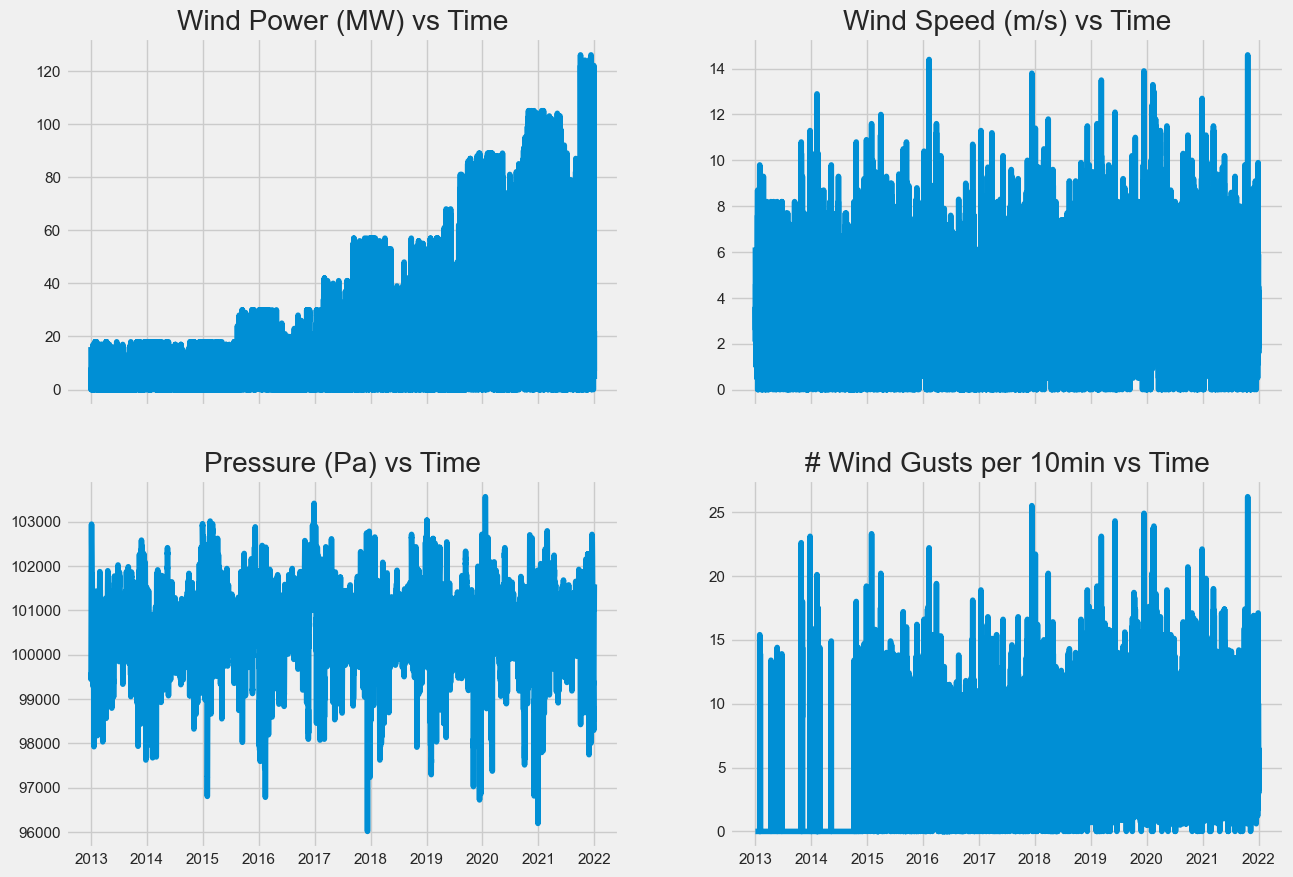

In [341]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True,figsize=(14,10))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(df.index, df['Wind_MW'])
ax2.plot(df.index, df['meanWindSpeed10min_mps'])
ax3.plot(df.index, df['pressureStation'])
ax4.plot(df.index, df['gusts_10min'])
ax1.title.set_text('Wind Power (MW) vs Time')
ax2.title.set_text('Wind Speed (m/s) vs Time')
ax3.title.set_text('Pressure (Pa) vs Time')
ax4.title.set_text('# Wind Gusts per 10min vs Time')
plt.show()

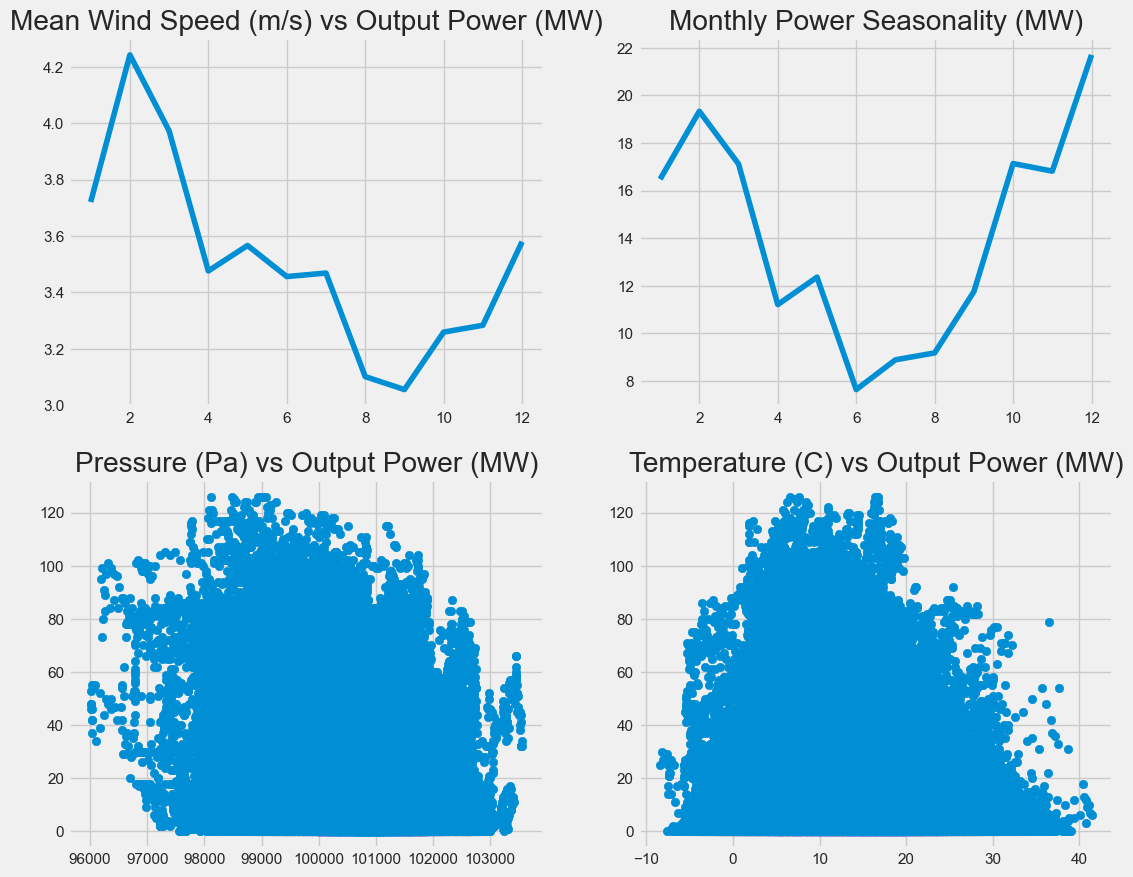

In [342]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
ax1, ax2, ax3, ax4 = axes.flatten()

avgMWperMonthNum = df.groupby('MonthNum')['Wind_MW'].mean()
avgWSperMonthNum = df.groupby('MonthNum')['meanWindSpeed10min_mps'].mean()
monthNum = range(1,13)

ax1.plot(monthNum, avgWSperMonthNum)
ax2.plot(monthNum, avgMWperMonthNum)
ax3.scatter(df['pressureStation'], df['Wind_MW'])
ax4.scatter(df['temperature_C'], df['Wind_MW'])
ax1.title.set_text('Mean Wind Speed (m/s) vs Output Power (MW)')
ax2.title.set_text('Monthly Power Seasonality (MW)')
ax3.title.set_text('Pressure (Pa) vs Output Power (MW)')
ax4.title.set_text('Temperature (C) vs Output Power (MW)')
plt.show()

We see some pretty clear seasonality patterns between summer, spring, fall, and winter, so lets try and find some more patterns by looking at various patterns across variables.

/home/jtotiker/Documents/DataScience/Projects/metroscope_project/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


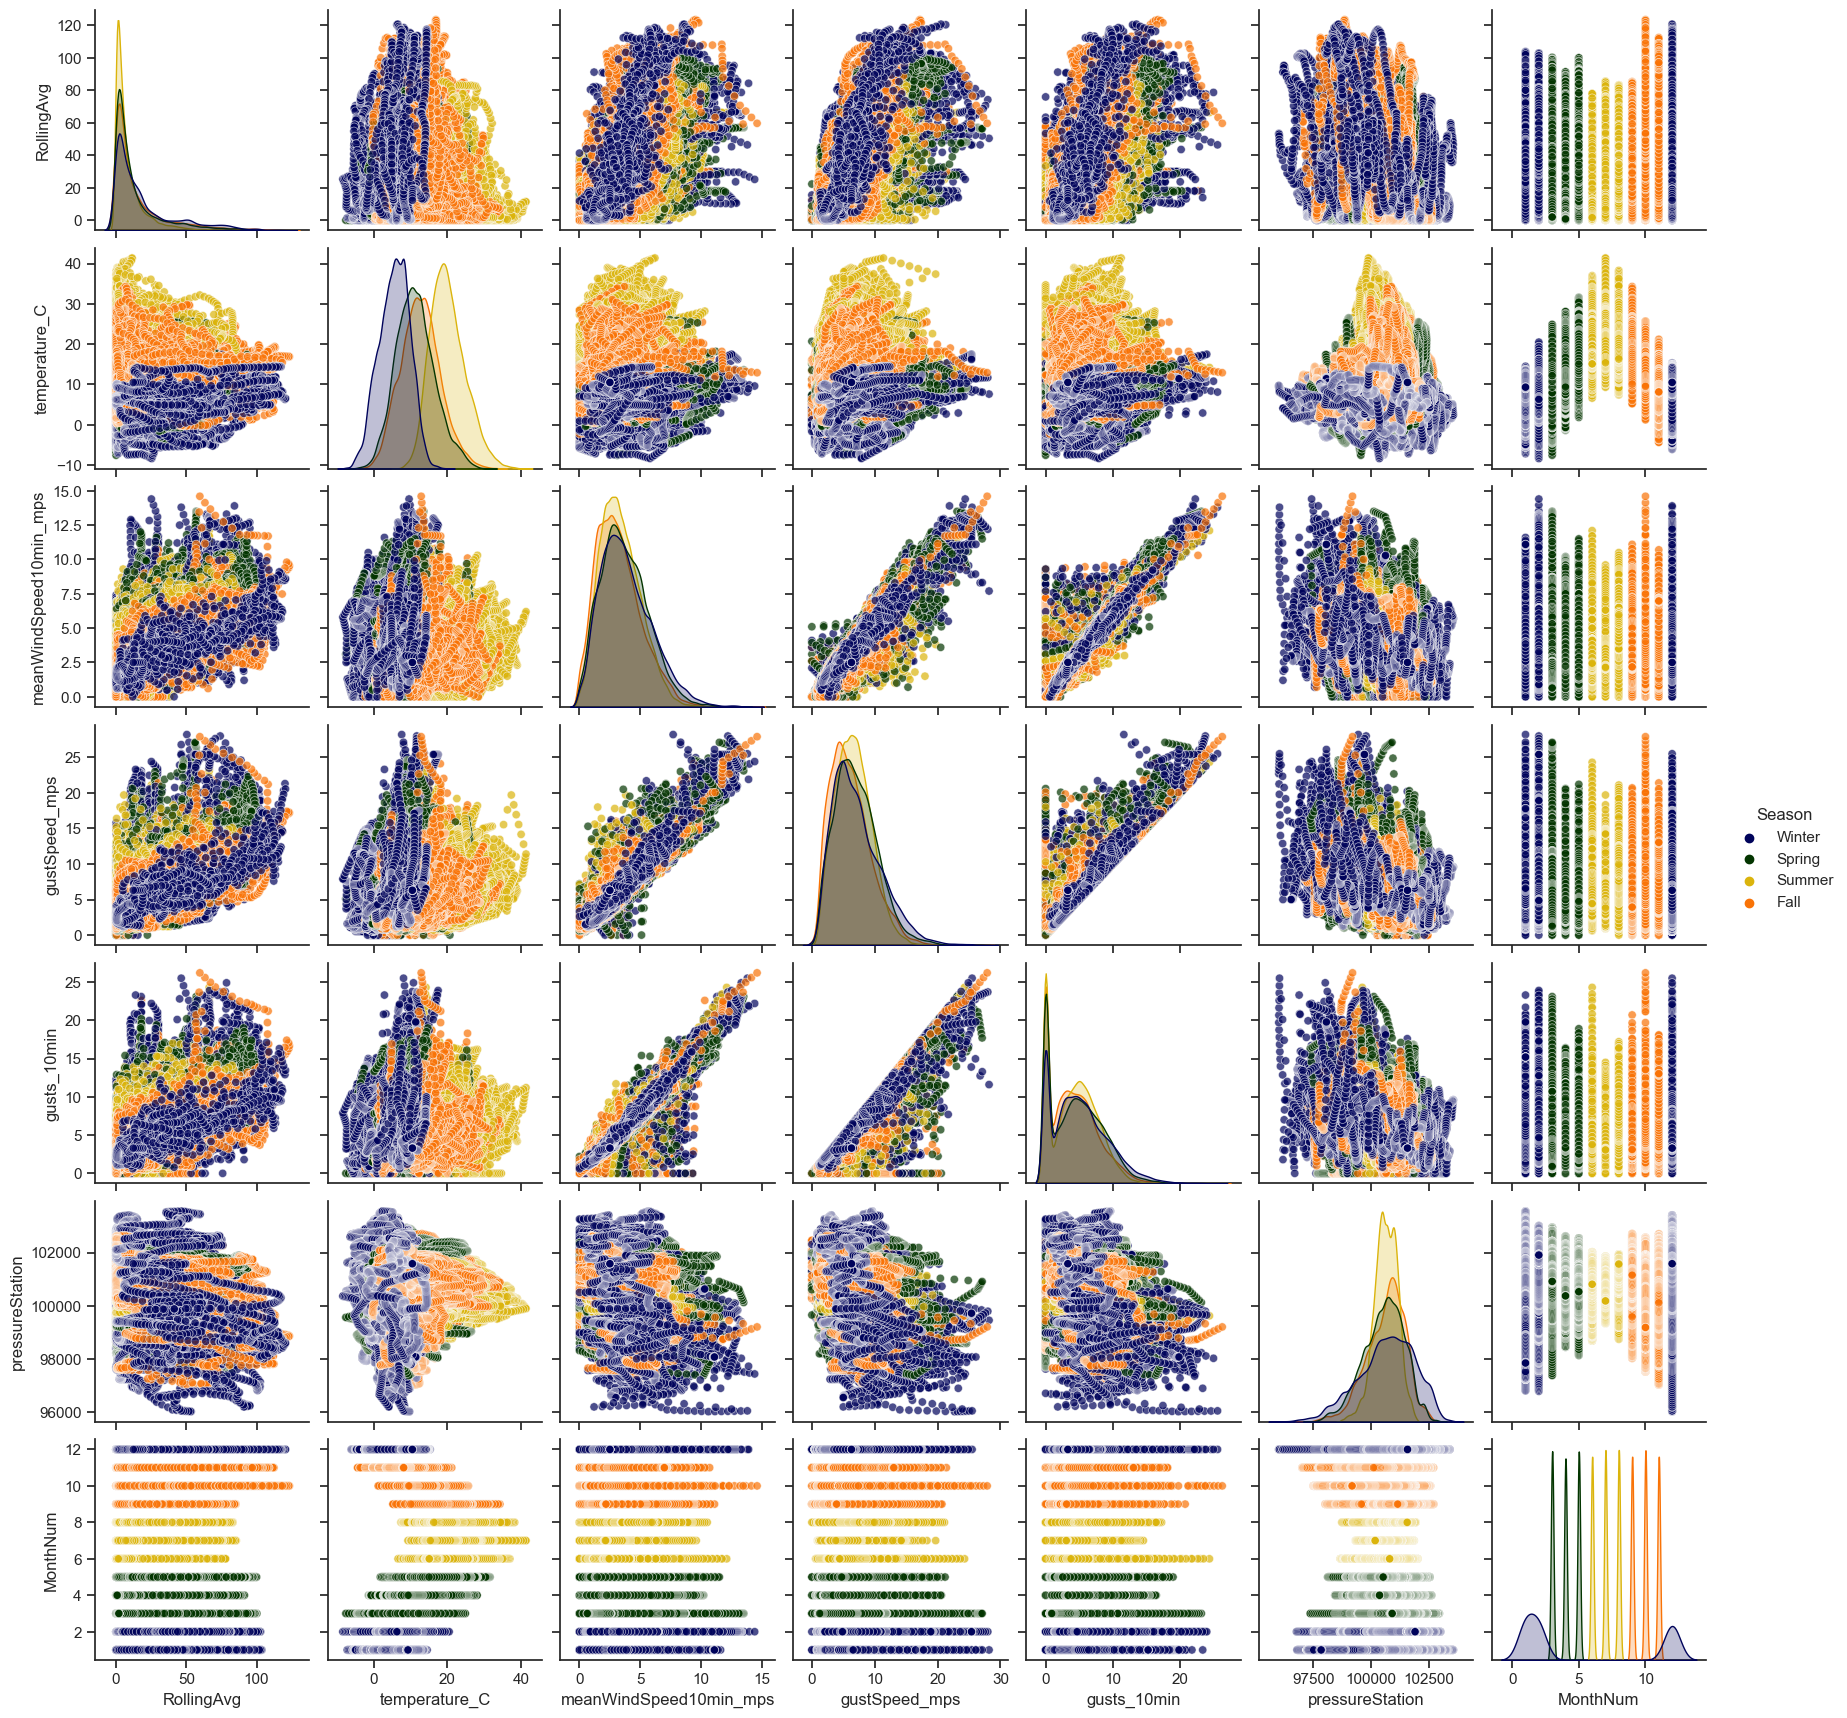

In [343]:
# Create empty seasons to populate
seasons = []

# Logic of matching month number to season
for month in df['MonthNum']:
    if month in [1, 2, 12]:
        seasons.append('Winter')
    elif month in [3, 4, 5]:
        seasons.append('Spring')
    elif month in [6, 7, 8]:
        seasons.append('Summer')
    elif month in [9, 10, 11]:
        seasons.append('Fall')

# Dual plotting with my chosen variables from dataframe
dualplot = df[['RollingAvg', 'temperature_C', 'meanWindSpeed10min_mps','gustSpeed_mps', 
               'gusts_10min', 'pressureStation','MonthNum']]
dualplot['Season'] = seasons


sns.set(style="ticks", color_codes=True);

# Match seasonal colors to seasons
seasonColors = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])

# Make the pair plot with a some aesthetic changes
sns.pairplot(dualplot, hue = 'Season', diag_kind = 'kde', palette= seasonColors, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(fill=True)); 

#### Choosing Features
- Our time information to relate back to later
- What will be our label for training, Wind_MW
- Our daily average in wind energy output for the baseline
- Our weather information that has strong seasonality patterns which all contributes to the seaonality we see above

In [376]:
features = df[['Year','MonthNum','DayNum','Hour','Wind_MW','Installed_MW','pressureSeaLevel_Pa','meanWindDir_10min',
               'meanWindSpeed10min_mps','temperature_C','humidity_per','pressureStation',
               'gusts_10min','gustSpeed_mps','rainfall3h_mm']]
features = pd.get_dummies(features)
features.columns.tolist()

['Year',
 'MonthNum',
 'DayNum',
 'Hour',
 'Wind_MW',
 'Installed_MW',
 'pressureSeaLevel_Pa',
 'meanWindDir_10min',
 'meanWindSpeed10min_mps',
 'temperature_C',
 'humidity_per',
 'pressureStation',
 'gusts_10min',
 'gustSpeed_mps',
 'rainfall3h_mm']

### 4. Model Implementation
Assign labels, split data into test and training sets, and establish baseline. Then use Random Forest regressor from sklearn as our model. 

#### Set Labels - what we want to predict with our model

In [377]:
# Labels are the values we want to predict
labels = np.array(features['Wind_MW'])

features = features.drop('Wind_MW', axis=1)

feature_list = list(features.columns)

features = np.array(features)

#### Split data into training and testing sets
- We check our array sizes to ensure data is split good

In [378]:
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size=0.25, random_state=101)

print('Training Features : ', train_features.shape)
print('Training Labels : ', train_labels.shape)
print('Testing Features : ', test_features.shape)
print('Testing Labels : ', test_labels.shape)

Training Features :  (118332, 14)
Training Labels :  (118332,)
Testing Features :  (39444, 14)
Testing Labels :  (39444,)


- Set baseline
- Calculate absolute error between baseline and obeserved values to compare our model with

In [361]:
#baseline = test_features[:,feature_list.index('RollingAvg')]
#
#baseline_errors = abs(baseline - test_labels)
#
#print(np.shape(train_features))
#train_features = np.delete(train_features, feature_list.index('RollingAvg'))
#print(np.shape(train_features))
#print('Average Baseline Error', round(np.mean(baseline_errors),2), 'MW.')

(1774979,)
(1774978,)
Average Baseline Error 3.65 MW.


#### Let's take hike into the Forest

- Can handle linear and nonlinear relationships
- Works well with large number of features if wanted to look at more weather data

In [379]:
rf = RandomForestRegressor(n_estimators=500,random_state=101)

rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=500, random_state=101)

- Calculate our absolute error between predictions and observed values

### 5. Model Evaluation
- Calculate mean absolute error as baseline to see how much better the model is than just looking at daily average

In [380]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)

print('Mean Abs Error:', round(np.mean(errors), 2), 'MW.')

Mean Abs Error: 2.91 MW.


#### Check feature importance in our model
- The baseline played the largest role, followed by historical percentage of production being utilized
- The year over year increasing trend also played a large role, which matches with the increase in installed MW
- From a basic knowledge of wind energy, the wind speed and direction are important in calculating wind power output. Gust speed plays the largest role in terms of physical weather, followed by the average wind speed at the station
- The month number seasonality plays a less important role than expected, but it's importance could be baked into the seasonality of wind speed and gusts seen, which are higher in the colder months

In [381]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:17} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: gusts_10min       Importance: 0.323
Variable: Installed_MW      Importance: 0.128
Variable: Year              Importance: 0.109
Variable: gustSpeed_mps     Importance: 0.079
Variable: meanWindSpeed10min_mps Importance: 0.075
Variable: humidity_per      Importance: 0.058
Variable: MonthNum          Importance: 0.044
Variable: temperature_C     Importance: 0.044
Variable: Hour              Importance: 0.037
Variable: meanWindDir_10min Importance: 0.032
Variable: DayNum            Importance: 0.021
Variable: pressureStation   Importance: 0.021
Variable: pressureSeaLevel_Pa Importance: 0.019
Variable: rainfall3h_mm     Importance: 0.011


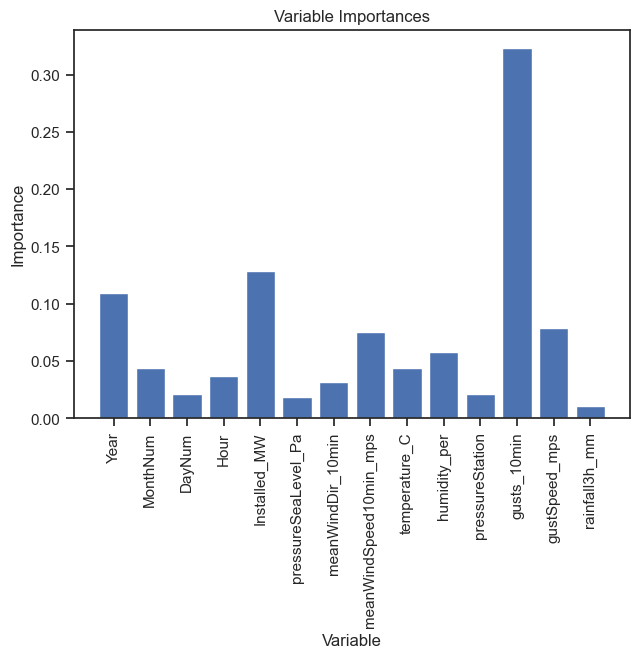

In [382]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### Final Plotting of Results
- As expected for a random forest regression we stay within the bounds of our data and don't extrapolate further, causing us to generally underforecast

/tmp/ipykernel_1151/10162588.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(Forecast['timeStamp'], Forecast['Forecast'], 'ro', marker='x', markersize=5, label = 'Forecasted Values')


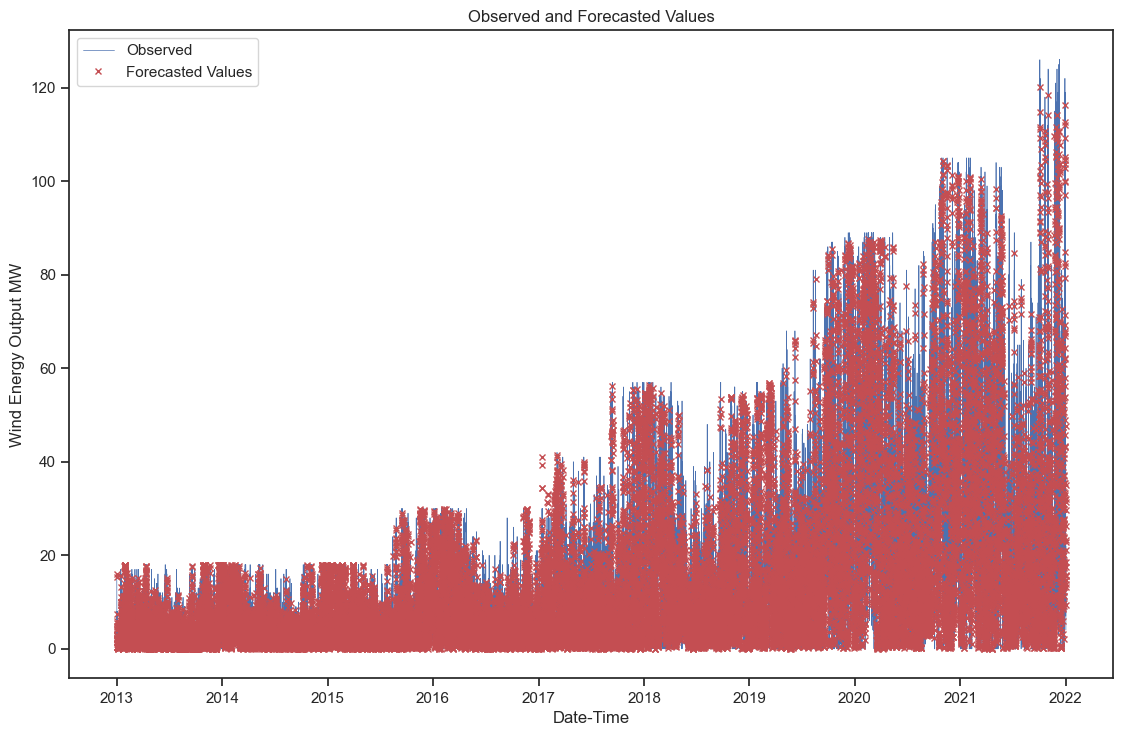

In [383]:
from matplotlib.pyplot import figure

years = features[:, feature_list.index('Year')]
months = features[:, feature_list.index('MonthNum')]
days = features[:, feature_list.index('DayNum')]
hours = features[:, feature_list.index('Hour')]
dateStr = [str(int(year)) + '-' + str(int(month)) + '-' +
        str(int(day)) + ' ' + str(int(hour))
          for year,month,day,hour in zip(years,months,days,hours)]
timeStamp = [datetime.datetime.strptime(date, '%Y-%m-%d %H') for date in
        dateStr]

Observed = pd.DataFrame(data = {'timeStamp':timeStamp, 'Observed':labels})

years = test_features[:, feature_list.index('Year')]
months = test_features[:, feature_list.index('MonthNum')]
days = test_features[:, feature_list.index('DayNum')]
hours = test_features[:, feature_list.index('Hour')]
dateStr = [str(int(year)) + '-' + str(int(month)) + '-' +
        str(int(day)) + ' ' + str(int(hour))
          for year,month,day,hour in zip(years,months,days,hours)]
timeStampT = [datetime.datetime.strptime(date, '%Y-%m-%d %H') for date in
        dateStr]

Forecast = pd.DataFrame(data={'timeStamp':timeStampT, 'Forecast':predictions})

figure(figsize=(12, 8), dpi=100)
plt.plot(Observed['timeStamp'], Observed['Observed'], 'b-',linewidth=0.5, label = 'Observed')
# Plot the predicted values
plt.plot(Forecast['timeStamp'], Forecast['Forecast'], 'ro', marker='x', markersize=5, label = 'Forecasted Values')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Date-Time'); plt.ylabel('Wind Energy Output MW'); plt.title('Observed and Forecasted Values');

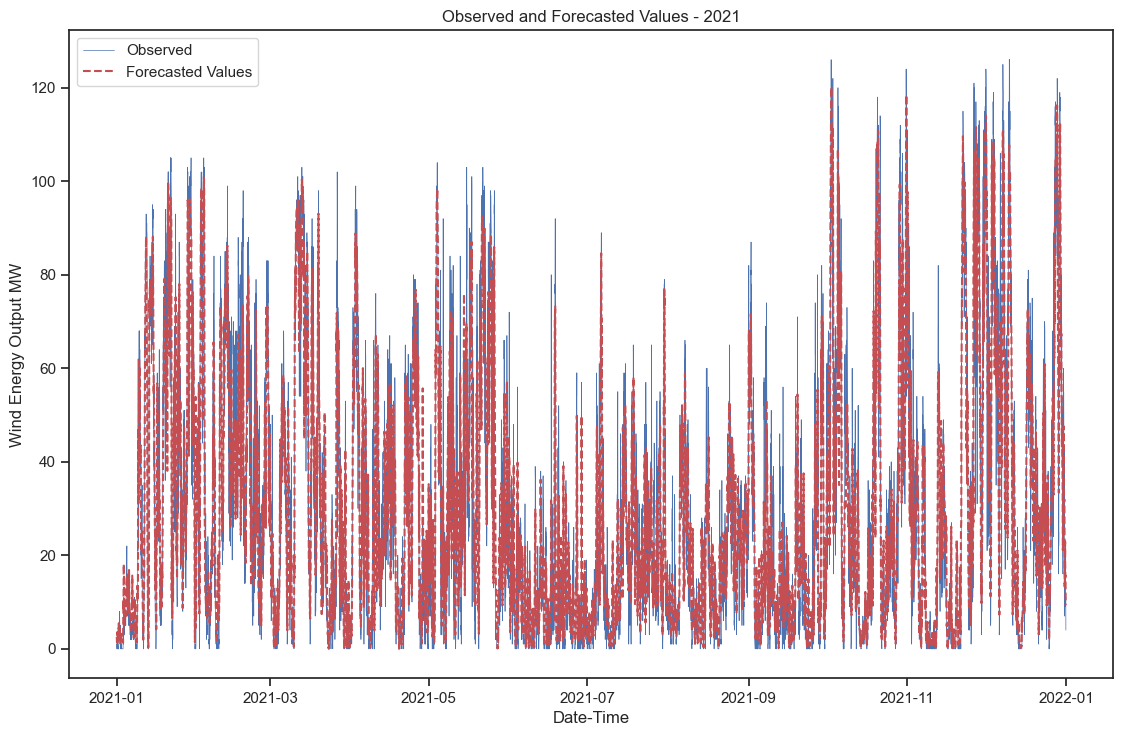

In [384]:
ObservedZoom = Observed[(Observed['timeStamp'] > '2021-01-01')] 
ForecastZoom = Forecast[(Forecast['timeStamp'] > '2021-01-01')]
ForecastZoom.sort_values(by=['timeStamp'], inplace=True)
figure(figsize=(12, 8), dpi=100)
plt.plot(ObservedZoom['timeStamp'], ObservedZoom['Observed'], 'b-',linewidth=0.5, label = 'Observed')
# Plot the predicted values
plt.plot(ForecastZoom['timeStamp'], ForecastZoom['Forecast'], 'r--', label = 'Forecasted Values')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Date-Time'); plt.ylabel('Wind Energy Output MW')
plt.title('Observed and Forecasted Values - 2021');

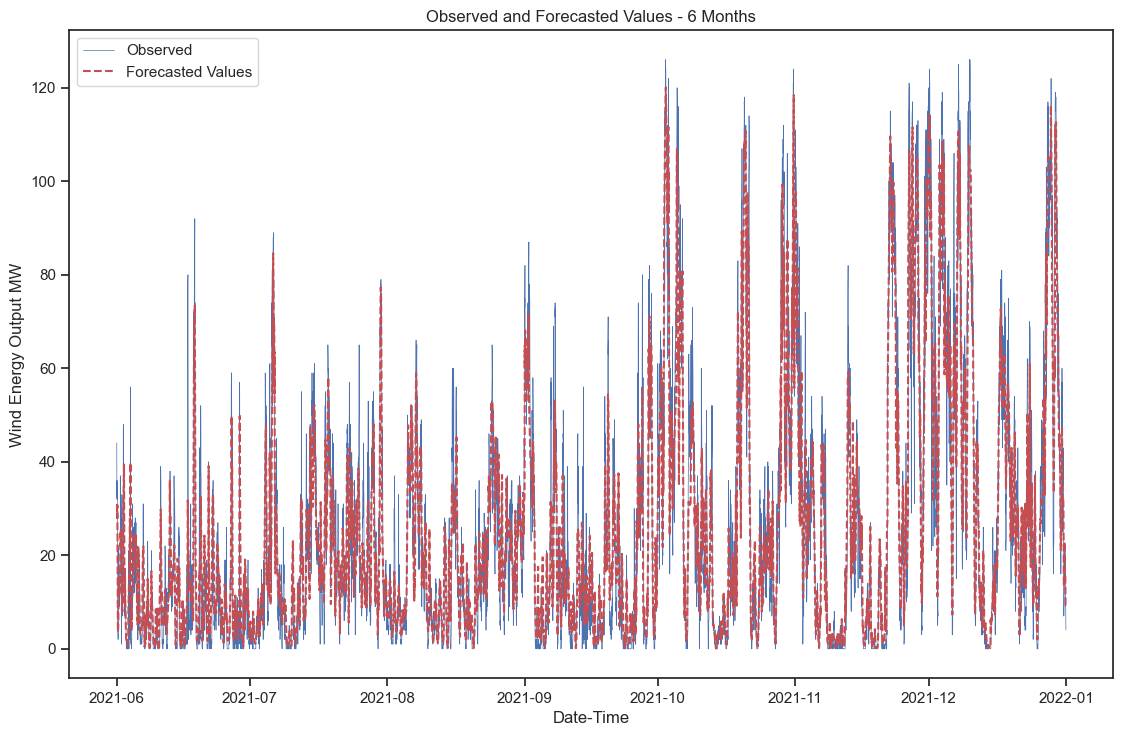

In [385]:
ObservedZoom = Observed[(Observed['timeStamp'] > '2021-06-01')] 
ForecastZoom = Forecast[(Forecast['timeStamp'] > '2021-06-01')]
ForecastZoom.sort_values(by=['timeStamp'], inplace=True)
figure(figsize=(12, 8), dpi=100)
plt.plot(ObservedZoom['timeStamp'], ObservedZoom['Observed'], 'b-',linewidth=0.5, label = 'Observed')
# Plot the predicted values
plt.plot(ForecastZoom['timeStamp'], ForecastZoom['Forecast'], 'r--', label = 'Forecasted Values')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Date-Time'); plt.ylabel('Wind Energy Output MW')
plt.title('Observed and Forecasted Values - 6 Months');

## Improvements
- Find more data
- More feature testing and then feature reduction based off of their importance 
- Test out other models that are better suited for regression analysis